<a href="https://colab.research.google.com/github/DavidGetter1/PolarSemEval/blob/main/POLAR_2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Pretrained model definition and libraries

Download pretrained model.

In [ ]:
!pip install --upgrade "accelerate>=0.26.0"

In [ ]:
!pip install transformers

In [ ]:
# Disable wandb to prevent interactive prompts
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "bert-base-multilingual-cased"
print("Loading model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Loading model and tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Data collection and preprocessing

Unpack training data. (COLAB: upload subtask1.zip)

In [ ]:
!unzip subtask1.zip -d /content/

Archive:  subtask1.zip
   creating: /content/train/
  inflating: /content/train/amh.csv  
  inflating: /content/train/arb.csv  
  inflating: /content/train/ben.csv  
  inflating: /content/train/deu.csv  
  inflating: /content/train/eng.csv  
  inflating: /content/train/fas.csv  
  inflating: /content/train/hau.csv  
  inflating: /content/train/hin.csv  
  inflating: /content/train/ita.csv  
  inflating: /content/train/khm.csv  
  inflating: /content/train/mya.csv  
  inflating: /content/train/nep.csv  
  inflating: /content/train/ori.csv  
  inflating: /content/train/pan.csv  
  inflating: /content/train/pol.csv  
  inflating: /content/train/rus.csv  
  inflating: /content/train/spa.csv  
  inflating: /content/train/swa.csv  
  inflating: /content/train/tel.csv  
  inflating: /content/train/tur.csv  
  inflating: /content/train/urd.csv  
  inflating: /content/train/zho.csv  
   creating: /content/dev/
  inflating: /content/dev/amh.csv    
  inflating: /content/dev/arb.csv    
  inflati

Load training data. (from POLAR@SEM-EVAL2026 https://polar-semeval.github.io/tasks.html)

In [ ]:
import glob
import os
from datasets import load_dataset

# Check current directory
print(f"Current directory: {os.getcwd()}")

# Collect all CSV paths for train and dev
train_files = glob.glob("train/*.csv")
dev_files = glob.glob("dev/*.csv")

# Load them into a DatasetDict
dataset = load_dataset(
    "csv",
    data_files={"train": train_files, "test": dev_files},
    column_names=["id", "text", "label"]  # 'polarization' mapped to 'label' for Trainer compatibility
)

Current directory: /content


Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Tokenize data.

⚠️*Attention: max_length can cutoff data*⚠️

In [ ]:
import glob
import torch
from datasets import load_dataset
from transformers import AutoTokenizer

# 1. Setup Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

# 2. Identify Files - ONLY use train (dev has no labels!)
train_files = glob.glob("train/*.csv")

# 3. Load CSVs with proper header handling
raw_datasets = load_dataset(
    "csv",
    data_files={"train": train_files},
    # Don't override column_names - let it read the header
)

# Rename 'polarization' to 'label' for Trainer compatibility
raw_datasets = raw_datasets.rename_column("polarization", "label")

# 4. ROBUST PREPROCESSING
def clean_and_tokenize(examples):
    clean_labels = []
    for val in examples["label"]:
        try:
            clean_labels.append(int(str(val).strip()))
        except (ValueError, TypeError):
            clean_labels.append(0)

    tokenized = tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        # max_length=128
        max_length=256
    )

    tokenized["labels"] = clean_labels
    return tokenized

# 5. Apply preprocessing
tokenized_datasets = raw_datasets.map(
    clean_and_tokenize,
    batched=True,
    remove_columns=raw_datasets["train"].column_names
)

# 6. Split training data: 92% train, 8% eval for better error analysis
split_datasets = tokenized_datasets["train"].train_test_split(test_size=0.08, seed=42)
shuffled_datasets = {
    "train": split_datasets["train"].shuffle(seed=42),
    "test": split_datasets["test"]  # This is our holdout for evaluation
}

print(f"Training samples: {len(shuffled_datasets['train'])}")
print(f"Evaluation samples: {len(shuffled_datasets['test'])}")
print("Sample labels:", shuffled_datasets["train"]["labels"][:20])

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/73681 [00:00<?, ? examples/s]

Training samples: 67786
Evaluation samples: 5895
Sample labels: [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1]


### Check class distribution over languages.

In [ ]:
import os
import glob
import pandas as pd
from datasets import Dataset, DatasetDict

# 1. Helper to extract language from filename (e.g., "train/en_train.csv" -> "en")
def get_lang_from_path(path):
    filename = os.path.basename(path)
    # Adjust this split logic if your filenames follow a different pattern
    return filename.split('_')[0]

# 2. Load files manually to preserve the language source
train_files = glob.glob("train/*.csv")
all_data = []

for f in train_files:
    df = pd.read_csv(f)
    # Map polarization to label immediately
    if "polarization" in df.columns:
        df = df.rename(columns={"polarization": "label"})

    # Add language column
    df["lang"] = get_lang_from_path(f)
    all_data.append(df)

# Combine into one Pandas DataFrame and then to HF Dataset
full_df = pd.concat(all_data, ignore_index=True)
raw_dataset = Dataset.from_pandas(full_df)

# 3. Clean labels (Robustness check)
def clean_labels(example):
    try:
        example["label"] = int(str(example["label"]).strip())
    except:
        example["label"] = 0
    return example

raw_dataset = raw_dataset.map(clean_labels)

# 4. Perform the Split (92% / 8%)
# We use the raw_dataset here so we still have the 'lang' column
split_datasets = raw_dataset.train_test_split(test_size=0.08, seed=42)

# 5. Function to print distribution
def print_distribution(dataset_split, split_name):
    print(f"\n--- Distribution for {split_name} ---")
    df = dataset_split.to_pandas()

    # Group by language and label
    dist = df.groupby(['lang', 'label']).size().unstack(fill_value=0)

    # Calculate percentages
    dist_pct = dist.div(dist.sum(axis=1), axis=0) * 100

    # Combine for display
    summary = pd.concat([dist, dist_pct], axis=1, keys=['Count', 'Percentage (%)'])
    print(summary)

# 6. View Distributions
print_distribution(split_datasets["train"], "TRAIN SPLIT")
print_distribution(split_datasets["test"], "TEST SPLIT (Eval)")

# Note: You can now proceed to tokenize, but ensure you
# keep the 'lang' column if you want to perform per-language evaluation later!

Map:   0%|          | 0/73681 [00:00<?, ? examples/s]


--- Distribution for TRAIN SPLIT ---
        Count       Percentage (%)           
label       0     1              0          1
lang                                         
amh.csv   733  2320      24.009171  75.990829
arb.csv  1724  1367      55.774830  44.225170
ben.csv  1752  1297      57.461463  42.538537
deu.csv  1554  1397      52.660115  47.339885
eng.csv  1901  1067      64.049865  35.950135
fas.csv   786  2243      25.949158  74.050842
hau.csv  3002   364      89.185977  10.814023
hin.csv   367  2171      14.460205  85.539795
ita.csv  1832  1240      59.635417  40.364583
khm.csv   563  5557       9.199346  90.800654
mya.csv  1100  1548      41.540785  58.459215
nep.csv   924   921      50.081301  49.918699
ori.csv  1553   631      71.108059  28.891941
pan.csv   787   767      50.643501  49.356499
pol.csv  1293   924      58.322057  41.677943
rus.csv  2120   939      69.303694  30.696306
spa.csv  1513  1529      49.737015  50.262985
swa.csv  3217  3220      49.976697  50.023

Visualize the distribtuion.

/tmp/ipython-input-3300219728.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
/tmp/ipython-input-3300219728.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')


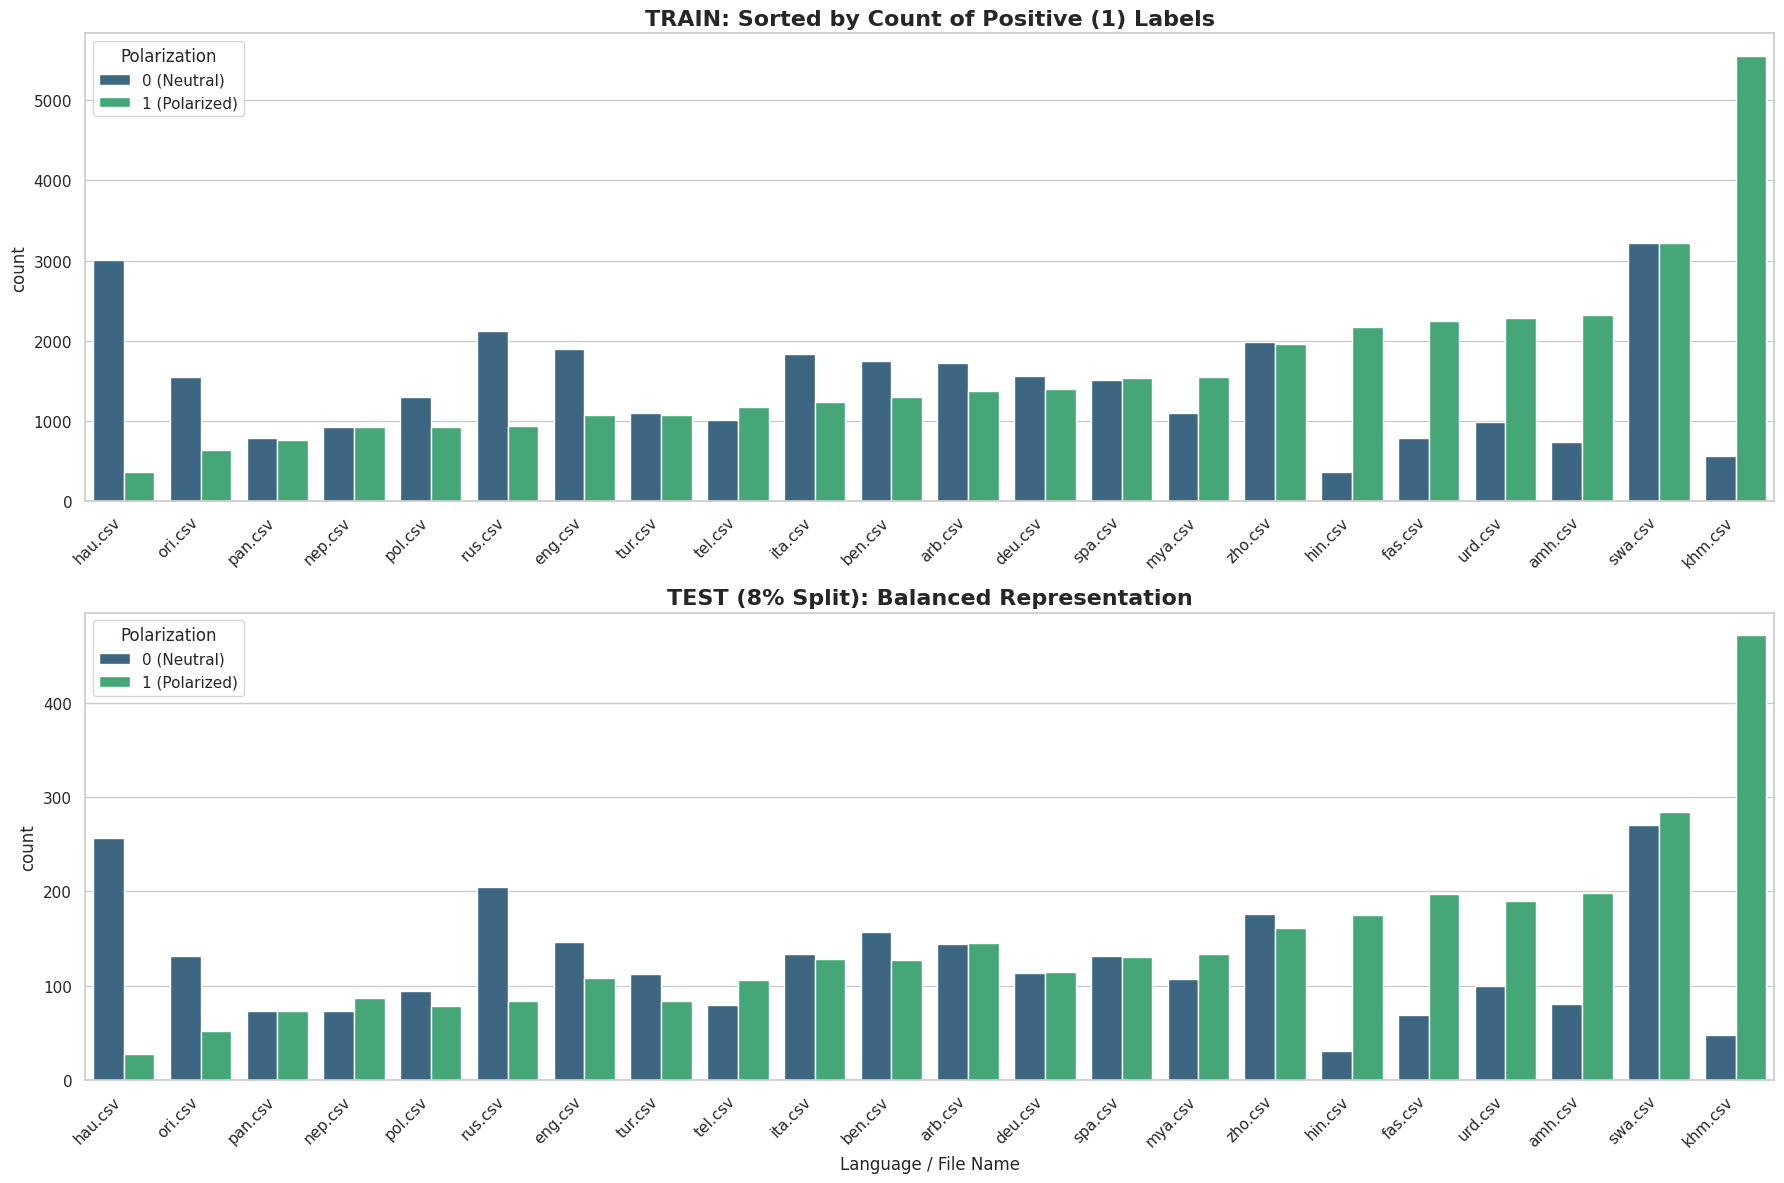

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import glob

def visualize_sorted_distribution(split_datasets):
    # 1. Convert to Pandas for manipulation
    train_df = split_datasets["train"].to_pandas()
    test_df = split_datasets["test"].to_pandas()

    # 2. Determine sorting order based on count of label 1 in TRAIN
    # We group by 'lang', count where label == 1, and sort ascending
    order_df = train_df[train_df['label'] == 1].groupby('lang').size().reset_index(name='pos_count')

    # Ensure languages with 0 positive samples are included in the order
    all_langs = pd.DataFrame({'lang': train_df['lang'].unique()})
    order_df = all_langs.merge(order_df, on='lang', how='left').fillna(0)

    # Sort ascending by pos_count
    sorted_langs = order_df.sort_values('pos_count')['lang'].tolist()

    # 3. Setup Plotting
    sns.set_theme(style="whitegrid")
    # Increase width (20) to handle 22 x-axis labels
    fig, axes = plt.subplots(2, 1, figsize=(18, 12))

    # --- TRAIN PLOT ---
    sns.countplot(
        data=train_df,
        x='lang',
        hue='label',
        ax=axes[0],
        palette='viridis',
        order=sorted_langs
    )
    axes[0].set_title('TRAIN: Sorted by Count of Positive (1) Labels', fontsize=16, fontweight='bold')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
    axes[0].set_xlabel('') # Hide x-label for the top plot for cleaner look
    axes[0].legend(title='Polarization', labels=['0 (Neutral)', '1 (Polarized)'])

    # --- TEST PLOT ---
    sns.countplot(
        data=test_df,
        x='lang',
        hue='label',
        ax=axes[1],
        palette='viridis',
        order=sorted_langs # Keep same order for comparison
    )
    axes[1].set_title('TEST (8% Split): Balanced Representation', fontsize=16, fontweight='bold')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
    axes[1].set_xlabel('Language / File Name')
    axes[1].legend(title='Polarization', labels=['0 (Neutral)', '1 (Polarized)'])

    plt.tight_layout()
    plt.savefig('sorted_distribution.png', dpi=300)
    plt.show()

# Run the visualization
visualize_sorted_distribution(split_datasets)

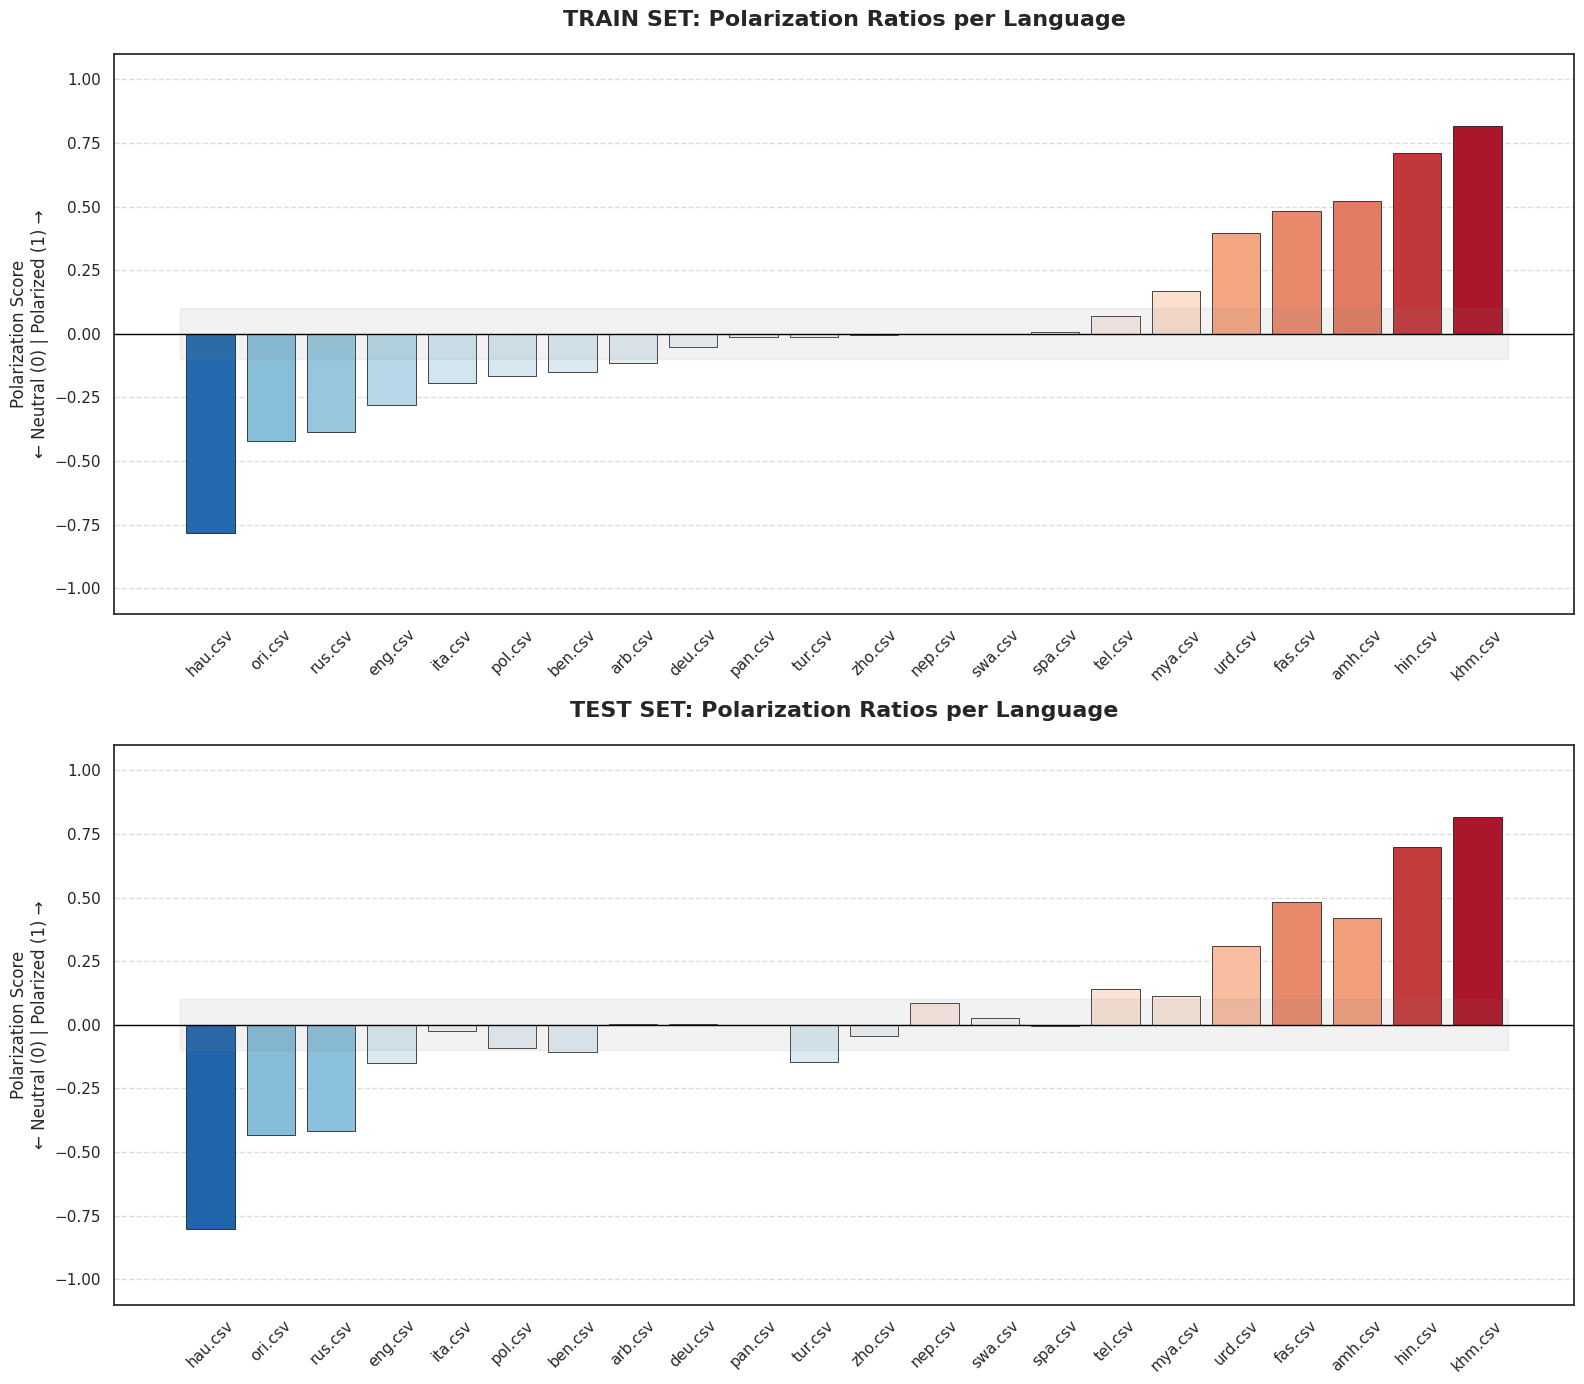

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def visualize_ratio_split_separated(split_datasets):
    # 1. Prepare Data
    train_df = split_datasets["train"].to_pandas()
    test_df = split_datasets["test"].to_pandas()

    def get_stats(df):
        counts = df.groupby(['lang', 'label']).size().unstack(fill_value=0)
        if 0 not in counts: counts[0] = 0
        if 1 not in counts: counts[1] = 0
        # Formula: (Pos - Neg) / Total
        counts['ratio'] = (counts[1] - counts[0]) / (counts[1] + counts[0])
        return counts.reset_index()

    train_stats = get_stats(train_df).sort_values('ratio')
    test_stats = get_stats(test_df)
    # Ensure test split follows the same language order as train
    test_stats = test_stats.set_index('lang').reindex(train_stats['lang']).reset_index().fillna(0)

    # 2. Setup Plot
    sns.set_theme(style="white")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 14))

    # Custom function to draw the bars
    def draw_diverging_bars(data, ax, title):
        # Create a color map based on the ratio values
        colors = plt.cm.RdBu_r((data['ratio'] + 1) / 2)

        bars = ax.bar(data['lang'], data['ratio'], color=colors, edgecolor='black', linewidth=0.5)

        ax.axhline(0, color='black', linewidth=1)
        ax.set_ylim(-1.1, 1.1)
        ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
        ax.set_ylabel('Polarization Score\n← Neutral (0) | Polarized (1) →', fontsize=12)
        ax.tick_params(axis='x', rotation=45)

        # Grid for readability
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)

        # Label the "Neutral Zone"
        ax.fill_between([-0.5, len(data)-0.5], -0.1, 0.1, color='gray', alpha=0.1, label='Balanced Zone')

    # 3. Execution
    draw_diverging_bars(train_stats, ax1, 'TRAIN SET: Polarization Ratios per Language')
    draw_diverging_bars(test_stats, ax2, 'TEST SET: Polarization Ratios per Language')

    plt.tight_layout()
    plt.savefig('split_ratios_diverging.png', dpi=300)
    plt.show()

# Run the visualization
visualize_ratio_split_separated(split_datasets)

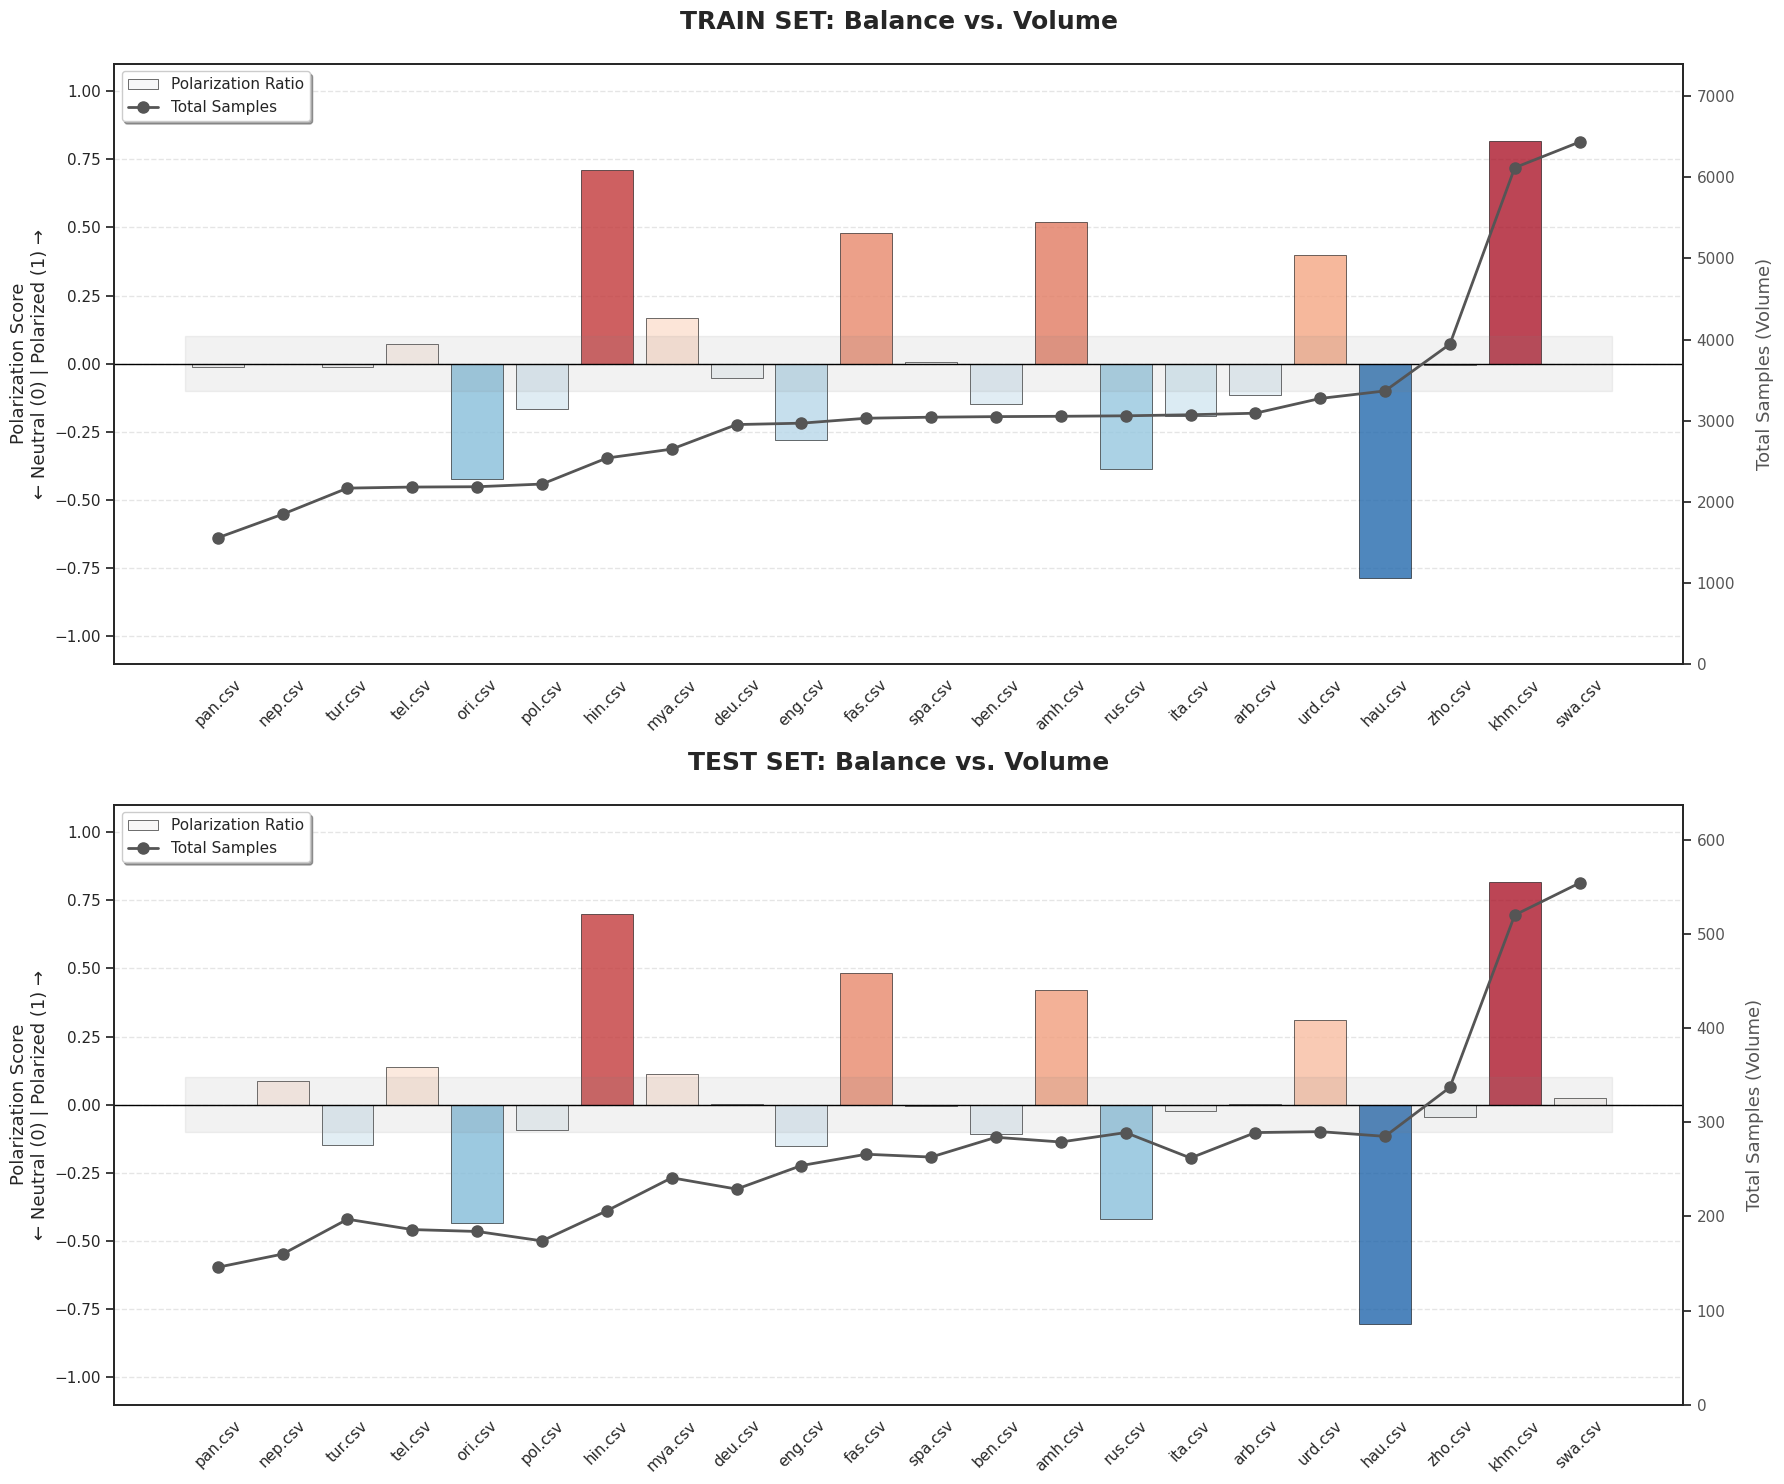

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def visualize_ratio_and_volume(split_datasets):
    # 1. Prepare Data
    train_df = split_datasets["train"].to_pandas()
    test_df = split_datasets["test"].to_pandas()

    def get_stats(df):
        counts = df.groupby(['lang', 'label']).size().unstack(fill_value=0)
        # Ensure columns exist even if data is missing
        if 0 not in counts: counts[0] = 0
        if 1 not in counts: counts[1] = 0

        # Calculate Total and Ratio
        counts['total'] = counts[0] + counts[1]
        counts['ratio'] = (counts[1] - counts[0]) / counts['total']
        return counts.reset_index()

    # train_stats = get_stats(train_df).sort_values('ratio')
    train_stats = get_stats(train_df).sort_values('total')
    test_stats = get_stats(test_df)

    # Align test set to train set order
    test_stats = test_stats.set_index('lang').reindex(train_stats['lang']).reset_index().fillna(0)


    # 2. Setup Plot
    sns.set_theme(style="white")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 15))

    def draw_combined_plot(data, ax, title):
        # --- Primary Axis: Ratios (Bars) ---
        colors = plt.cm.RdBu_r((data['ratio'] + 1) / 2)
        bars = ax.bar(data['lang'], data['ratio'], color=colors, edgecolor='black', linewidth=0.5, alpha=0.8, label='Polarization Ratio')

        ax.axhline(0, color='black', linewidth=1)
        ax.set_ylim(-1.1, 1.1)
        ax.set_title(title, fontsize=18, fontweight='bold', pad=25)
        ax.set_ylabel('Polarization Score\n← Neutral (0) | Polarized (1) →', fontsize=13)
        ax.tick_params(axis='x', rotation=45)
        ax.yaxis.grid(True, linestyle='--', alpha=0.5)

        # Balanced zone shading
        ax.fill_between([-0.5, len(data)-0.5], -0.1, 0.1, color='gray', alpha=0.1)

        # --- Secondary Axis: Sample Counts (Line) ---
        ax_vol = ax.twinx()
        ax_vol.plot(data['lang'], data['total'], color='#555555', marker='o', markersize=8,
                    linestyle='-', linewidth=2, label='Total Samples')

        # Set secondary axis limits to start at 0 with some padding for labels
        ax_vol.set_ylim(0, data['total'].max() * 1.15)
        ax_vol.set_ylabel('Total Samples (Volume)', fontsize=13, color='#555555', labelpad=15)
        ax_vol.tick_params(axis='y', labelcolor='#555555')

        # Combine legends from both axes
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax_vol.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc='upper left', frameon=True, shadow=True)

    # 3. Execute
    draw_combined_plot(train_stats, ax1, 'TRAIN SET: Balance vs. Volume')
    draw_combined_plot(test_stats, ax2, 'TEST SET: Balance vs. Volume')

    plt.tight_layout()
    plt.savefig('balance_and_volume_analysis.png', dpi=300)
    plt.show()

# Run the updated visualization
visualize_ratio_and_volume(split_datasets)

### Baseline

Define evaluation metrics.

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # mBERT outputs logits; we take the argmax to get the 0 or 1 prediction
    predictions = np.argmax(logits, axis=-1)

    # 'macro' average treats both classes (0 and 1) as equally important
    # regardless of how many samples each has in your CSVs.
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='macro'
    )
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'f1_macro': f1,
        'precision_macro': precision,
        'recall_macro': recall
    }

⚠️DEPRECATED?⚠️

Test baseline performance. (on **GPU**!)

In [ ]:
###################################################
###################################################
################## DEPRECATED ?? ##################
###################################################
###################################################

from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification
import pandas as pd
import glob
import os
from tqdm import tqdm

# Load model with classification head
model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)

# Set up arguments for prediction
pred_args = TrainingArguments(
    output_dir="./baseline",
    per_device_eval_batch_size=32,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=pred_args,
)

# Create baseline output directory
os.makedirs("./baseline", exist_ok=True)

# Get all dev files (these have ids but no labels - for submission)
dev_files = glob.glob("dev/*.csv")

print(f"Generating baseline predictions for {len(dev_files)} languages...")

for dev_file in tqdm(dev_files):
    # Extract language code from filename (e.g., "dev/eng.csv" -> "eng")
    lang_code = os.path.basename(dev_file).replace('.csv', '')

    # Load dev data
    dev_df = pd.read_csv(dev_file)

    # Tokenize the text
    dev_encodings = tokenizer(
        dev_df['text'].tolist(),
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

    # Create a simple dataset
    class SimpleDataset:
        def __init__(self, encodings):
            self.encodings = encodings

        def __getitem__(self, idx):
            return {key: val[idx] for key, val in self.encodings.items()}

        def __len__(self):
            return len(self.encodings['input_ids'])

    dev_dataset = SimpleDataset(dev_encodings)

    # Get predictions
    predictions = trainer.predict(dev_dataset)

    # DEBUG: Check the raw logits
    print(f"\nDEBUG - First 5 samples for {lang_code}:")
    print("Raw logits (class 0, class 1):")
    print(predictions.predictions[:5])
    print("\nArgmax predictions:")
    print(predictions.predictions.argmax(axis=-1)[:5])

    pred_labels = predictions.predictions.argmax(axis=-1)

    # Create submission dataframe
    submission_df = pd.DataFrame({
        'id': dev_df['id'],
        'polarization': pred_labels
    })

    # Save in submission format
    output_path = f"./baseline/pred_{lang_code}.csv"
    submission_df.to_csv(output_path, index=False)

    print(f"  ✓ {lang_code}: {len(submission_df)} predictions -> {output_path}")

print(f"\n✓ All baseline predictions saved to ./baseline/")
print(f"  Files: pred_{{lang_code}}.csv for each language")

###################################################
###################################################
################## DEPRECATED ?? ##################
###################################################
###################################################

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Generating baseline predictions for 22 languages...


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]


KeyboardInterrupt: 

Train the classification head.

In [ ]:
import gc
import torch

# Delete any existing model/trainer from previous cells
for var_name in ['model', 'trainer', 'baseline_results']:
    if var_name in dir():
        exec(f"del {var_name}")

# Force garbage collection
gc.collect()

# Clear all CUDA memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()

    # Show current memory state
    allocated = torch.cuda.memory_allocated() / 1e9
    reserved = torch.cuda.memory_reserved() / 1e9
    total = torch.cuda.get_device_properties(0).total_memory / 1e9

    print(f"GPU Memory after cleanup:")
    print(f"  Allocated: {allocated:.2f} GB")
    print(f"  Reserved:  {reserved:.2f} GB")
    print(f"  Total:     {total:.2f} GB")
    print(f"  Free:      {total - reserved:.2f} GB")

GPU Memory after cleanup:
  Allocated: 0.00 GB
  Reserved:  0.00 GB
  Total:     15.83 GB
  Free:      15.83 GB


In [ ]:
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification
import torch
import os

# Memory optimization environment variable
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Clear CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

# Load fresh model with classification head
model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)

# Training arguments - SPEED OPTIMIZED for T4 GPU with clean memory
training_args = TrainingArguments(
    output_dir="./mbert_polarization",

    # Training settings - MAXIMIZED for speed
    num_train_epochs=3,
    per_device_train_batch_size=16,   # Increased from 4
    per_device_eval_batch_size=32,    # Increased from 8
    gradient_accumulation_steps=2,    # Reduced: effective batch = 16 * 2 = 32

    # Learning rate schedule
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,

    # Evaluation & saving - less frequent = faster
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,

    # Logging - less frequent
    logging_steps=200,
    report_to="none",

    # T4 SPEED OPTIMIZATIONS
    fp16=True,                        # Tensor Cores = 2-3x faster
    bf16=False,                       # T4 doesn't support bf16
    dataloader_pin_memory=True,       # Faster CPU->GPU transfer
    dataloader_num_workers=4,         # More parallel data loading
    optim="adamw_torch_fused",        # Fused optimizer (faster)
    torch_compile=False,              # Skip compilation overhead

    # No gradient checkpointing = faster (uses more memory but we have it now)
    gradient_checkpointing=False,
    max_grad_norm=1.0,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=shuffled_datasets["train"],
    eval_dataset=shuffled_datasets["test"],
    compute_metrics=compute_metrics,
)

# Train!
print("Starting training (T4 GPU - SPEED optimized)...")
print(f"Using device: {trainer.args.device}")
print(f"Batch size: {training_args.per_device_train_batch_size} x {training_args.gradient_accumulation_steps} = {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
trainer.train()

# Final evaluation
final_results = trainer.evaluate()
print(f"\n=== Training Complete ===")
print(f"Final Macro F1: {final_results['eval_f1_macro']:.4f}")
print(f"Final Accuracy: {final_results['eval_accuracy']:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training (T4 GPU - SPEED optimized)...
Using device: cuda:0
Batch size: 16 x 2 = 32


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,0.474500,0.440845,0.789822,0.789120,0.788807,0.789750
2,0.393700,0.431761,0.793723,0.792410,0.792824,0.792093
3,0.294700,0.485024,0.799661,0.798497,0.798705,0.798318


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: T


=== Training Complete ===
Final Macro F1: 0.7985
Final Accuracy: 0.7997


Analyze predictions on 8% holdout set

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import os

# Create analysis directory
os.makedirs("./analysis", exist_ok=True)

# Get predictions on the 8% holdout set
print("Generating predictions on 8% holdout set...")
test_predictions = trainer.predict(shuffled_datasets["test"])
pred_labels = test_predictions.predictions.argmax(axis=-1)
true_labels = np.array(shuffled_datasets["test"]["labels"])

# Calculate metrics
print("\n=== Evaluation Metrics ===")
print(f"Accuracy: {(pred_labels == true_labels).mean():.4f}")
print(f"\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=['Non-polarized (0)', 'Polarized (1)']))

print(f"\nConfusion Matrix:")
cm = confusion_matrix(true_labels, pred_labels)
print(f"                  Predicted 0  Predicted 1")
print(f"Actual 0 (TN/FP):      {cm[0,0]:5d}        {cm[0,1]:5d}")
print(f"Actual 1 (FN/TP):      {cm[1,0]:5d}        {cm[1,1]:5d}")

# Need to reconstruct the original text from the test set
# We'll need to reload the data to get the text and IDs
print("\n=== Creating detailed analysis CSV ===")

# Load all training data again to match with indices
train_files = glob.glob("train/*.csv")
all_data = []
for file in train_files:
    df = pd.read_csv(file)
    all_data.append(df)

combined_df = pd.concat(all_data, ignore_index=True)

# Split the same way to get the test indices
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(combined_df, test_size=0.08, random_state=42)

# Create analysis dataframe
analysis_df = pd.DataFrame({
    'id': test_df['id'].values,
    'text': test_df['text'].values,
    'true_label': true_labels,
    'predicted_label': pred_labels,
    'correct': pred_labels == true_labels
})

# Add language code (extracted from id)
analysis_df['language'] = analysis_df['id'].str.split('_').str[0]

# Sort by incorrect predictions first, then by language
analysis_df = analysis_df.sort_values(['correct', 'language', 'id'])

# Save overall analysis
output_file = './analysis/predictions_analysis.csv'
analysis_df.to_csv(output_file, index=False)
print(f"✓ Saved overall analysis: {output_file}")
print(f"  Total samples: {len(analysis_df)}")
print(f"  Correct: {analysis_df['correct'].sum()} ({100*analysis_df['correct'].mean():.2f}%)")
print(f"  Incorrect: {(~analysis_df['correct']).sum()} ({100*(~analysis_df['correct']).mean():.2f}%)")

# Save errors only (for easier manual review)
errors_df = analysis_df[~analysis_df['correct']]
errors_file = './analysis/errors_only.csv'
errors_df.to_csv(errors_file, index=False)
print(f"\n✓ Saved errors only: {errors_file}")
print(f"  Total errors: {len(errors_df)}")

# Save per-language breakdown
print(f"\n=== Per-Language Performance ===")
lang_stats = analysis_df.groupby('language').agg({
    'correct': ['count', 'sum', 'mean']
}).round(4)
lang_stats.columns = ['total', 'correct', 'accuracy']
lang_stats = lang_stats.sort_values('accuracy')

lang_stats_file = './analysis/per_language_accuracy.csv'
lang_stats.to_csv(lang_stats_file)
print(lang_stats)
print(f"\n✓ Saved language stats: {lang_stats_file}")

# Save False Positives and False Negatives separately
fp_df = analysis_df[(analysis_df['true_label'] == 0) & (analysis_df['predicted_label'] == 1)]
fn_df = analysis_df[(analysis_df['true_label'] == 1) & (analysis_df['predicted_label'] == 0)]

if len(fp_df) > 0:
    fp_file = './analysis/false_positives.csv'
    fp_df.to_csv(fp_file, index=False)
    print(f"\n✓ False Positives: {len(fp_df)} samples → {fp_file}")

if len(fn_df) > 0:
    fn_file = './analysis/false_negatives.csv'
    fn_df.to_csv(fn_file, index=False)
    print(f"✓ False Negatives: {len(fn_df)} samples → {fn_file}")

print(f"\n{'='*60}")
print(f"All analysis files saved to ./analysis/")
print(f"{'='*60}")

#################################### Actually save the model ####################################

# Create a directory for the model checkpoint
model_output_dir = "./mbert_polarized_model"
os.makedirs(model_output_dir, exist_ok=True)

print(f"\n=== Saving Model Checkpoint ===")
# Save the model weights and configuration
trainer.save_model(model_output_dir)

# Save the tokenizer (very important for mBERT to keep the vocab)
tokenizer.save_pretrained(model_output_dir)

print(f"✓ Model and tokenizer saved to: {model_output_dir}")

#################################### Actually save the model ####################################

Generating predictions on 8% holdout set...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



=== Evaluation Metrics ===
Accuracy: 0.7997

Classification Report:
                   precision    recall  f1-score   support

Non-polarized (0)       0.79      0.78      0.78      2736
    Polarized (1)       0.81      0.82      0.81      3159

         accuracy                           0.80      5895
        macro avg       0.80      0.80      0.80      5895
     weighted avg       0.80      0.80      0.80      5895


Confusion Matrix:
                  Predicted 0  Predicted 1
Actual 0 (TN/FP):       2133          603
Actual 1 (FN/TP):        578         2581

=== Creating detailed analysis CSV ===
✓ Saved overall analysis: ./analysis/predictions_analysis.csv
  Total samples: 5895
  Correct: 4714 (79.97%)
  Incorrect: 1181 (20.03%)

✓ Saved errors only: ./analysis/errors_only.csv
  Total errors: 1181

=== Per-Language Performance ===
          total  correct  accuracy
language                          
tel         189      139    0.7354
mya         216      164    0.7593
ben     

Quantize the model to make it fit in a browser extension (Target < 200 MB)

In [19]:
pip install "optimum-onnx[onnxruntime]"

In [20]:
import os
from optimum.onnxruntime import ORTModelForSequenceClassification
from onnxruntime.quantization import quantize_dynamic, QuantType

# Paths
model_input_dir = "./mbert_polarized_model"
onnx_output_dir = "./onnx_output"
os.makedirs(onnx_output_dir, exist_ok=True)

raw_onnx_path = os.path.join(onnx_output_dir, "model.onnx")
quantized_onnx_path = os.path.join(onnx_output_dir, "model_quantized.onnx")

print("--- Step 1: Exporting to ONNX ---")
# Use the correct ORTModel class (requires optimum-onnx)
model = ORTModelForSequenceClassification.from_pretrained(model_input_dir, export=True)
model.save_pretrained(onnx_output_dir)

print("\n--- Step 2: Quantizing to INT8 ---")
quantize_dynamic(
    model_input=raw_onnx_path,
    model_output=quantized_onnx_path,
    weight_type=QuantType.QUInt8
)

# 3. Final Size Check
def get_mb(path):
    return os.path.getsize(path) / (1024 * 1024)

print(f"\nFinal Quantized Size: {get_mb(quantized_onnx_path):.2f} MB")

Multiple distributions found for package optimum. Picked distribution: optimum
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
`torch_dtype` is deprecated! Use `dtype` instead!


--- Step 1: Exporting to ONNX ---


The tokenizer you are loading from './mbert_polarized_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
The tokenizer you are loading from './mbert_polarized_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
The tokenizer you are loading from './mbert_polarized_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tok


--- Step 2: Quantizing to INT8 ---



Final Quantized Size: 170.34 MB


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score # Added f1_score
import os
import glob

# Create analysis directory
os.makedirs("./analysis", exist_ok=True)

# Get predictions on the 8% holdout set
print("Generating predictions on 8% holdout set...")
test_predictions = trainer.predict(shuffled_datasets["test"])
pred_labels = test_predictions.predictions.argmax(axis=-1)
true_labels = np.array(shuffled_datasets["test"]["labels"])

# Calculate metrics
print("\n=== Evaluation Metrics ===")
# --- NEW: MACRO F1 PRINTING ---
macro_f1 = f1_score(true_labels, pred_labels, average='macro')
print(f"Accuracy: {(pred_labels == true_labels).mean():.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")
# ------------------------------

print(f"\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=['Non-polarized (0)', 'Polarized (1)']))

print(f"\nConfusion Matrix:")
cm = confusion_matrix(true_labels, pred_labels)
print(f"                Predicted 0  Predicted 1")
print(f"Actual 0 (TN/FP):      {cm[0,0]:5d}         {cm[0,1]:5d}")
print(f"Actual 1 (FN/TP):      {cm[1,0]:5d}         {cm[1,1]:5d}")

# Need to reconstruct the original text from the test set
print("\n=== Creating detailed analysis CSV ===")

# Load all training data again to match with indices
train_files = glob.glob("train/*.csv")
all_data = []
for file in train_files:
    df = pd.read_csv(file)
    all_data.append(df)

combined_df = pd.concat(all_data, ignore_index=True)

# Split the same way to get the test indices
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(combined_df, test_size=0.08, random_state=42)

# Create analysis dataframe
analysis_df = pd.DataFrame({
    'id': test_df['id'].values,
    'text': test_df['text'].values,
    'true_label': true_labels,
    'predicted_label': pred_labels,
    'correct': pred_labels == true_labels
})

# Add language code (extracted from id)
analysis_df['language'] = analysis_df['id'].str.split('_').str[0]

# Sort by incorrect predictions first, then by language
analysis_df = analysis_df.sort_values(['correct', 'language', 'id'])

# Save overall analysis
output_file = './analysis/predictions_analysis.csv'
analysis_df.to_csv(output_file, index=False)
print(f"✓ Saved overall analysis: {output_file}")
print(f"  Total samples: {len(analysis_df)}")
print(f"  Correct: {analysis_df['correct'].sum()} ({100*analysis_df['correct'].mean():.2f}%)")
print(f"  Incorrect: {(~analysis_df['correct']).sum()} ({100*(~analysis_df['correct']).mean():.2f}%)")

# Save errors only
errors_df = analysis_df[~analysis_df['correct']]
errors_file = './analysis/errors_only.csv'
errors_df.to_csv(errors_file, index=False)
print(f"\n✓ Saved errors only: {errors_file}")
print(f"  Total errors: {len(errors_df)}")

# Save per-language breakdown
print(f"\n=== Per-Language Performance ===")
lang_stats = analysis_df.groupby('language').agg({
    'correct': ['count', 'sum', 'mean']
}).round(4)
lang_stats.columns = ['total', 'correct', 'accuracy']
lang_stats = lang_stats.sort_values('accuracy')

lang_stats_file = './analysis/per_language_accuracy.csv'
lang_stats.to_csv(lang_stats_file)
print(lang_stats)
print(f"\n✓ Saved language stats: {lang_stats_file}")

# Save False Positives and False Negatives separately
fp_df = analysis_df[(analysis_df['true_label'] == 0) & (analysis_df['predicted_label'] == 1)]
fn_df = analysis_df[(analysis_df['true_label'] == 1) & (analysis_df['predicted_label'] == 0)]

if len(fp_df) > 0:
    fp_file = './analysis/false_positives.csv'
    fp_df.to_csv(fp_file, index=False)
    print(f"\n✓ False Positives: {len(fp_df)} samples → {fp_file}")

if len(fn_df) > 0:
    fn_file = './analysis/false_negatives.csv'
    fn_df.to_csv(fn_file, index=False)
    print(f"✓ False Negatives: {len(fn_df)} samples → {fn_file}")

print(f"\n{'='*60}")
print(f"All analysis files saved to ./analysis/")
print(f"{'='*60}")


#################################### Actually save the model ####################################

# Create a directory for the model checkpoint
model_output_dir = "./mbert_polarized_model"
os.makedirs(model_output_dir, exist_ok=True)

print(f"\n=== Saving Model Checkpoint ===")
# Save the model weights and configuration
trainer.save_model(model_output_dir)

# Save the tokenizer (very important for mBERT to keep the vocab)
tokenizer.save_pretrained(model_output_dir)

print(f"✓ Model and tokenizer saved to: {model_output_dir}")

#################################### Actually save the model ####################################

Generating predictions on 8% holdout set...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



=== Evaluation Metrics ===
Accuracy: 0.7997
Macro F1 Score: 0.7985

Classification Report:
                   precision    recall  f1-score   support

Non-polarized (0)       0.79      0.78      0.78      2736
    Polarized (1)       0.81      0.82      0.81      3159

         accuracy                           0.80      5895
        macro avg       0.80      0.80      0.80      5895
     weighted avg       0.80      0.80      0.80      5895


Confusion Matrix:
                Predicted 0  Predicted 1
Actual 0 (TN/FP):       2133           603
Actual 1 (FN/TP):        578          2581

=== Creating detailed analysis CSV ===
✓ Saved overall analysis: ./analysis/predictions_analysis.csv
  Total samples: 5895
  Correct: 4714 (79.97%)
  Incorrect: 1181 (20.03%)

✓ Saved errors only: ./analysis/errors_only.csv
  Total errors: 1181

=== Per-Language Performance ===
          total  correct  accuracy
language                          
tel         189      139    0.7354
mya         216     

Zip model for download (colab only).

In [ ]:
import shutil

# The folder you want to zip
folder_to_zip = 'mbert_polarized_model'

# The name of the output zip file (it will automatically add .zip)
output_filename = 'mbert_polarized_model_checkpoint'

# Create the zip archive
shutil.make_archive(output_filename, 'zip', folder_to_zip)

print(f"✓ Created {output_filename}.zip successfully!")

✓ Created mbert_polarized_model_checkpoint.zip successfully!


#### deprecated?

In [ ]:
###################################################
###################################################
################## DEPRECATED ?? ##################
###################################################
###################################################

import pandas as pd
import glob
import os
from tqdm import tqdm

# Create output directory for trained model predictions
os.makedirs("./trained_predictions", exist_ok=True)

# Get all dev files (these have ids but no labels - for submission)
dev_files = glob.glob("dev/*.csv")

print(f"Generating trained model predictions for {len(dev_files)} languages...")

for dev_file in tqdm(dev_files):
    # Extract language code from filename (e.g., "dev/eng.csv" -> "eng")
    lang_code = os.path.basename(dev_file).replace('.csv', '')

    # Load dev data
    dev_df = pd.read_csv(dev_file)

    # Tokenize the text
    dev_encodings = tokenizer(
        dev_df['text'].tolist(),
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

    # Create a simple dataset
    class SimpleDataset:
        def __init__(self, encodings):
            self.encodings = encodings

        def __getitem__(self, idx):
            return {key: val[idx] for key, val in self.encodings.items()}

        def __len__(self):
            return len(self.encodings['input_ids'])

    dev_dataset = SimpleDataset(dev_encodings)

    # Get predictions from TRAINED model using existing trainer
    predictions = trainer.predict(dev_dataset)
    pred_labels = predictions.predictions.argmax(axis=-1)

    # Create submission dataframe
    submission_df = pd.DataFrame({
        'id': dev_df['id'],
        'polarization': pred_labels
    })

    # Save in submission format
    output_path = f"./trained_predictions/pred_{lang_code}.csv"
    submission_df.to_csv(output_path, index=False)

    print(f"  ✓ {lang_code}: {len(submission_df)} predictions -> {output_path}")

print(f"\n✓ All trained model predictions saved to ./trained_predictions/")
print(f"  Files: pred_{{lang_code}}.csv for each language")
print(f"\nYou can now submit the files from ./trained_predictions/ to Codabench!")

###################################################
###################################################
################## DEPRECATED ?? ##################
###################################################
###################################################

Generating trained model predictions for 22 languages...


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  5%|▍         | 1/22 [00:00<00:12,  1.73it/s]

  ✓ rus: 167 predictions -> ./trained_predictions/pred_rus.csv


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  9%|▉         | 2/22 [00:01<00:14,  1.41it/s]

  ✓ khm: 332 predictions -> ./trained_predictions/pred_khm.csv


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


 14%|█▎        | 3/22 [00:01<00:11,  1.69it/s]

  ✓ pan: 100 predictions -> ./trained_predictions/pred_pan.csv


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


 18%|█▊        | 4/22 [00:02<00:09,  1.82it/s]

  ✓ deu: 159 predictions -> ./trained_predictions/pred_deu.csv


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


 23%|██▎       | 5/22 [00:02<00:09,  1.87it/s]

  ✓ spa: 165 predictions -> ./trained_predictions/pred_spa.csv


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


 27%|██▋       | 6/22 [00:03<00:08,  1.86it/s]

  ✓ hau: 182 predictions -> ./trained_predictions/pred_hau.csv


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


 32%|███▏      | 7/22 [00:03<00:07,  1.97it/s]

  ✓ nep: 100 predictions -> ./trained_predictions/pred_nep.csv


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


 36%|███▋      | 8/22 [00:04<00:07,  1.82it/s]

  ✓ mya: 144 predictions -> ./trained_predictions/pred_mya.csv


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


 41%|████      | 9/22 [00:05<00:07,  1.81it/s]

  ✓ tel: 118 predictions -> ./trained_predictions/pred_tel.csv


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


 45%|████▌     | 10/22 [00:05<00:07,  1.66it/s]

  ✓ zho: 214 predictions -> ./trained_predictions/pred_zho.csv


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


 50%|█████     | 11/22 [00:06<00:06,  1.74it/s]

  ✓ arb: 169 predictions -> ./trained_predictions/pred_arb.csv


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


 55%|█████▍    | 12/22 [00:06<00:05,  1.79it/s]

  ✓ urd: 177 predictions -> ./trained_predictions/pred_urd.csv


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


 59%|█████▉    | 13/22 [00:07<00:04,  1.88it/s]

  ✓ hin: 137 predictions -> ./trained_predictions/pred_hin.csv


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


 64%|██████▎   | 14/22 [00:07<00:03,  2.01it/s]

  ✓ tur: 115 predictions -> ./trained_predictions/pred_tur.csv


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


 68%|██████▊   | 15/22 [00:08<00:03,  1.98it/s]

  ✓ ita: 166 predictions -> ./trained_predictions/pred_ita.csv


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


 73%|███████▎  | 16/22 [00:08<00:03,  1.96it/s]

  ✓ ben: 166 predictions -> ./trained_predictions/pred_ben.csv


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


 77%|███████▋  | 17/22 [00:09<00:02,  2.07it/s]

  ✓ ori: 118 predictions -> ./trained_predictions/pred_ori.csv


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


 82%|████████▏ | 18/22 [00:09<00:01,  2.07it/s]

  ✓ eng: 160 predictions -> ./trained_predictions/pred_eng.csv


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


 86%|████████▋ | 19/22 [00:10<00:01,  1.73it/s]

  ✓ swa: 349 predictions -> ./trained_predictions/pred_swa.csv


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


 91%|█████████ | 20/22 [00:10<00:01,  1.78it/s]

  ✓ fas: 164 predictions -> ./trained_predictions/pred_fas.csv


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


 95%|█████████▌| 21/22 [00:11<00:00,  1.83it/s]

  ✓ amh: 166 predictions -> ./trained_predictions/pred_amh.csv


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


100%|██████████| 22/22 [00:11<00:00,  1.86it/s]

  ✓ pol: 119 predictions -> ./trained_predictions/pred_pol.csv

✓ All trained model predictions saved to ./trained_predictions/
  Files: pred_{lang_code}.csv for each language

You can now submit the files from ./trained_predictions/ to Codabench!
